#### –û–±—É—á–µ–Ω–∏–µ —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä–∞ c –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Å–µ—Ç–∏ DaBERTa:

#### –û–±—É—á–µ–Ω–∏–µ –∏ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å –º–æ–¥–µ–ª–µ–π –ø—Ä–æ–∏—Å—Ö–æ–¥–∏–ª –Ω–∞ kaggle.com —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –±–µ—Å–ø–ª–∞—Ç–Ω–æ–≥–æ –Ω–µ–¥–µ–ª—å–Ω–æ–≥–æ –¥–æ—Å—Ç—É–ø–∞ –∫ GPU –±–ª–æ–∫—É A100.

#### –ó–∞–≥—Ä—É–∂–∞–µ–º –Ω–µ–¥–æ—Å—Ç–∞—é—â–∏–µ –º–æ–¥—É–ª–∏:

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datasets accelerate nvidia-ml-py3

  Preparing metadata (setup.py) ... - done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=2351baa583dafbbd12f89fcbaba44b296b7489381c83ad2bf058cc0aff46a78d
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
Note: you may need to restart the kernel to use updated packages.


#### –ò–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º –º–æ–¥—É–ª–∏:

In [4]:
import os
import string
import sys
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import datetime

import torch
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split,  RandomSampler, SequentialSampler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import summary, writer, SummaryWriter

from tqdm.notebook import tqdm


#### –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º Seed'—ã:

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

import warnings
warnings.filterwarnings("ignore")

#### –ó–∞–¥–∞—ë–º device:

In [6]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### –ò–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º –∏ —É—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ –≤—Å–µ, —á—Ç–æ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ:

In [7]:
!git clone https://github.com/KuzmaKhrabrov/character-tokenizer.git

Cloning into 'character-tokenizer'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 5), reused 10 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 5.89 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [8]:
sys.path.append("/kaggle/input/tools/character-tokenizer")
from charactertokenizer import CharacterTokenizer

#### Check:

In [9]:
chars = "–ê–∞–ë–±–í–≤–ì–≥–î–¥–ï–µ–Å—ë–ñ–∂–ó–∑–ò–∏–ô–π–ö–∫–õ–ª–ú–º–ù–Ω–û–æ–ü–ø–†—Ä–°—Å–¢—Ç–£—É–§—Ñ–•—Ö–¶—Ü–ß—á–®—à–©—â–™—ä–´—ã–¨—å–≠—ç–Æ—é–Ø—è-h"
model_max_length = 22
tokenizer = CharacterTokenizer(chars, model_max_length)

#### –ü—Ä–æ–≤–µ—Ä—è–µ–º Encode:

In [10]:
example = "-–±—Éh"
tokens = tokenizer(example)
print(tokens)

{'input_ids': [0, 73, 10, 48, 74, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


#### –ü—Ä–æ–≤–µ—Ä—è–µ–º Decode:

In [11]:
print(tokenizer.decode(tokens["input_ids"]))

[CLS]-–±—Éh[SEP]


#### –ó–∞–¥–∞—á–∞:

##### –ù–µ–æ–±—Ö–æ–¥–∏–º–æ –æ–±—É—á–∏—Ç—å –º–æ–¥–µ–ª—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –±—É–∫–≤ –¥–ª—è –∑–∞–¥–∞—á–∏ —Ä–∞—Å—Å—Ç–∞–Ω–æ–≤–∫–∏ —É–¥–∞—Ä–µ–Ω–∏—è —Å –ø–æ–º–æ—â—å—é –º–µ—Ç–æ–¥–æ–≤ –∏–∑ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ transformers.

1. –ù–∞–ø–∏—Å–∞—Ç—å –∫–ª–∞—Å—Å –¥–ª—è Dataset/Dataloder –∏ —Ä–∞–∑–±–∏—Ç—å –¥–∞–Ω–Ω—ã–µ –Ω–∞ —Å–ª—É—á–∞–π–Ω—ã–µ train / test —Å–ø–ª–∏—Ç—ã –≤ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–∏ 50:50. (1 –±–∞–ª–ª)
2. –ü–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –æ–±—É—á–∏—Ç—å –æ–¥–Ω—É –∏–ª–∏ –Ω–µ—Å–∫–æ–ª—å–∫–æ –∏–∑ –º–æ–¥–µ–ª–µ–π: Bert, Albert, Deberta. –ü–æ—Å—á–∏—Ç–∞—Ç—å –º–µ—Ç—Ä–∏–∫—É Accuracy –Ω–∞ train –∏ test. (1 –±–∞–ª–ª). –ü—Ä–∏ –ø—Ä–µ–æ–¥–æ–ª–µ–Ω–∏–∏ –ø–æ—Ä–æ–≥–∞ –≤ Accuracy –Ω–∞ test 0.8: (+1 –±–∞–ª–ª), 0.85: (+2 –±–∞–ª–ª–∞), 0.89: (+3 –±–∞–ª–ª–∞).

#### –î–∞—Ç–∞—Å–µ—Ç –∑–∞–≥—Ä—É–∂–µ–Ω, –ø—Ä–æ–≤–µ—Ä—è–µ–º –µ–≥–æ —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ:

In [12]:
accents_path = '/kaggle/input/accents-dataset/all_accents.tsv'
accents_dataset = pd.read_csv(accents_path, sep = '\t', header=0, encoding='utf-8', na_values='NA')

In [13]:
accents_dataset.head()

-–¥–µ      -–¥^–µ
0      -–∫–∞      -–∫^–∞
1    -–ª–∏–±–æ    -–ª^–∏–±–æ
2  -–Ω–∏–±—É–¥—å  -–Ω–∏–±^—É–¥—å
3       -—Å        -—Å
4    -—Ç–∞–∫–∏    -—Ç–∞–∫^–∏

#### –ù–µ–º–Ω–æ–≥–æ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–π –¥–∞—Ç–∞—Å–µ—Ç–∞:

In [14]:
# –ß–∏—Å–ª–æ –ø—Ä–∏–º–µ—Ä–æ–≤:
print(accents_dataset.shape[0])

1680534


In [ ]:
# –°–∏–º–≤–æ–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ —Å–ª–æ–≤
def word_length(word):
    '''–ü—Ä–æ—Å—Ç–æ –ø—Ä–∏–Ω–∏–º–∞–µ–º –Ω–∞ –≤—Ö–æ–¥ —Å–ª–æ–≤–æ –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ–º –µ–≥–æ –¥–ª–∏–Ω—É'''
    return len(word)

# –û–¥–∏–Ω —Å–∏–º–≤–æ–ª
def is_one_symbol(word):
    '''–í–æ–∑–≤—Ä–∞—â–∞–µ–º 1, –µ—Å–ª–∏ —Å–ª–æ–≤–æ –∏–º–µ–µ—Ç –æ–¥–∏–Ω —Å–∏–º–≤–æ–ª, –∏–Ω–∞—á–µ –≤–æ–∑–≤—Ä–∞—â–∞–µ–º 0'''
    return int(len(word) == 1)

# –ë–æ–ª—å—à–µ –æ–¥–Ω–æ–≥–æ —Å–ª–æ–≤–∞ —á–µ—Ä–µ–∑ –ø—Ä–æ–±–µ–ª
def more_than_one_word(word):
    '''–í–æ–∑–≤—Ä–∞—â–∞–µ–º 1, –µ—Å–ª–∏ –Ω–µ—Å–∫–æ–ª—å–∫–æ —Å–ª–æ–≤ –≤ –∑–∞–ø–∏—Å–∏, –∏–Ω–∞—á–µ 0'''
    splitted = word.split(' ')
    return int(len(splitted) > 1)

# –ü–æ–¥—Å—á–µ—Ç —Å–∏–º–≤–æ–ª–æ–≤ —É–¥–∞—Ä–µ–Ω–∏—è ^:
def count_hat(word):
    '''–°—á–∏—Ç–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–∏–º–≤–æ–ª–æ–≤ ^'''
    return len(re.findall(r'\^', word))

# –ï—Å—Ç—å –ª–∏ –ª–∞—Ç–∏–Ω—Å–∫–∏–µ –±—É–∫–≤—ã –≤ —Å–ª–æ–≤–µ
def contains_latin(word):
    '''–û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º —Å–ª—É—á–∞–∏ –Ω–∞–ª–∏—á–∏—è –ª–∞—Ç–∏–Ω—Å–∫–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ (bool flag)'''
    return int(bool(re.search(r'[a-zA-Z]', word)))

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ–¥—Å—á–µ—Ç–∞ —Å–∏–º–≤–æ–ª–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ —è–≤–ª—è—é—Ç—Å—è —Ä—É—Å—Å–∫–∏–º–∏ –±—É–∫–≤–∞–º–∏
def count_non_russian(word):
    '''–°—á–∏—Ç–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ –∫–∏—Ä–∏–ª–ª–∏—Ü—ã'''
    return len(re.findall(r'[a-zA-Z]', word))

def letter_yo(word):
    '''–û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º —Å–ª—É—á–∞–π –±—É–∫–≤—ã —ë–Å, –æ–Ω–∞ –≤—Å–µ–≥–¥–∞ —É–≥–∞—Ä–Ω–∞—è'''
    return int(bool(re.search(r'[—ë–Å]', word)))

def error_cases(word):
    '''–û–±—Ä–∞–±–æ—Ç–∫–∞ –æ—à–∏–±–æ–∫ (—É–¥–∞—Ä–µ–Ω–∏–µ –≤ —Å–ª–æ–≤–µ –ø–∞–¥–∞–µ—Ç –Ω–∞ —Å–æ–≥–ª–∞—Å–Ω—É—é –±—É–∫–≤—É)'''
    pattern = r'\^[–±–≤–≥–¥–∂–∑–π–∫–ª–º–Ω–ø—Ä—Å—Ç—Ñ—Ö—Ü—á—à—â–ë–í–ì–î–ñ–ó–ô–ö–õ–ú–ù–ü–†–°–¢–§–•–¶–ß–®–©]'   
    matches = re.findall(pattern, word)
    return len(matches)


accents_dataset['word_length'] = accents_dataset['-–¥–µ'].map(word_length)
accents_dataset['is_one_symbol'] = accents_dataset['-–¥–µ'].map(is_one_symbol)
accents_dataset['more_than_one_word'] = accents_dataset['-–¥–µ'].map(more_than_one_word)
accents_dataset['hat_num'] = accents_dataset['-–¥^–µ'].map(count_hat)
accents_dataset['has_latin'] = accents_dataset['-–¥–µ'].map(contains_latin)
accents_dataset['num_non_russian'] = accents_dataset['-–¥–µ'].map(count_non_russian)
accents_dataset['error_cases'] = accents_dataset['-–¥^–µ'].map(error_cases)
accents_dataset['is_–Å—ë'] = accents_dataset['-–¥–µ'].map(letter_yo)

In [16]:
# –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∏ —Å—Ä–µ–¥–Ω–µ–µ —á–∏—Å–ª–æ —Å–∏–º–≤–æ–ª–æ–≤ –≤ —Å–ª–æ–≤–µ:
word_max_length = accents_dataset['word_length'].max()
print(f"–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ —Å–∏–º–≤–æ–ª–æ–≤ –≤ —Å–ª–æ–≤–µ: {word_max_length}")

# –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ –∏ —Å—Ä–µ–¥–Ω–µ–µ —á–∏—Å–ª–æ —Å–∏–º–≤–æ–ª–æ–≤ –≤ —Å–ª–æ–≤–µ:
word_mean_length = accents_dataset['word_length'].mean()
print(f"–°—Ä–µ–¥–Ω–µ–µ —á–∏—Å–ª–æ —Å–∏–º–≤–æ–ª–æ–≤ –≤ —Å–ª–æ–≤–µ: {word_mean_length}")

–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ —Å–∏–º–≤–æ–ª–æ–≤ –≤ —Å–ª–æ–≤–µ: 56
–°—Ä–µ–¥–Ω–µ–µ —á–∏—Å–ª–æ —Å–∏–º–≤–æ–ª–æ–≤ –≤ —Å–ª–æ–≤–µ: 10.641052189363618


#### –ü–æ—Å–º–æ—Ç—Ä–∏–º –±–æ–ª–µ–µ –ø—Ä–∏—Å—Ç–∞–ª—å–Ω–æ –Ω–∞ —É–¥–∞—Ä–µ–Ω–∏—è:

In [17]:
accents_count_max = accents_dataset['hat_num'].max()
print(f"–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ —É–¥–∞—Ä–µ–Ω–∏–π –≤ —Å–ª–æ–≤–µ: {accents_count_max}")

zero_accents_num = accents_dataset[accents_dataset['hat_num'] == 0].shape[0]
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª—É—á–∞–µ–≤ –æ—Ç—Å—É—Ç—Å—Ç–≤–∏—è —É–¥–∞—Ä–µ–Ω–∏–π –≤ —Å–ª–æ–≤–∞—Ö: {zero_accents_num}")

–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ —É–¥–∞—Ä–µ–Ω–∏–π –≤ —Å–ª–æ–≤–µ: 1
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª—É—á–∞–µ–≤ –æ—Ç—Å—É—Ç—Å—Ç–≤–∏—è —É–¥–∞—Ä–µ–Ω–∏–π –≤ —Å–ª–æ–≤–∞—Ö: 507


–û—à–∏–±–æ–∫ –Ω–µ—Ç, –≥–¥–µ —É –Ω–∞—Å –±–æ–ª—å—à–µ –æ–¥–Ω–æ–≥–æ —É–¥–∞—Ä–µ–Ω–∏—è. –û–¥–Ω–∞–∫–æ —É –Ω–∞—Å —Ü–µ–ª—ã—Ö 507 —Å–ª—É—á–∞–µ–≤ –æ—Ç—Å—É—Ç—Å—Ç–≤–∏—è —É–¥–∞—Ä–µ–Ω–∏–π –≤ —Å–ª–æ–≤–∞—Ö:

In [18]:
accents_dataset[accents_dataset['hat_num'] == 0].head(10)

-–¥–µ         -–¥^–µ  word_length  is_one_symbol  \
3               -—Å           -—Å            2              0   
16107           –∞–π           –∞–π            2              0   
16172     –∞–π–≤–∏–Ω–≥—Ö–æ     –∞–π–≤–∏–Ω–≥—Ö–æ            8              0   
24766  –∞–ª–º–æ–Ω–¥—Å–±–µ—Ä–∏  –∞–ª–º–æ–Ω–¥—Å–±–µ—Ä–∏           11              0   
27255           –∞–º           –∞–º            2              0   
29041         –∞–º–∫–∞         –∞–º–∫–∞            4              0   
35185         –∞–Ω–∫–∞         –∞–Ω–∫–∞            4              0   
42254        –∞–Ω—å–∫–∞        –∞–Ω—å–∫–∞            5              0   
62526            –±            –±            1              1   
75305     –±–µ–¥–µ—Ä–Ω—ã–π     –±–µ–¥–µ—Ä–Ω—ã–π            8              0   

       more_than_one_word  hat_num  has_latin  num_non_russian  error_cases  \
3                       0        0          0                0            0   
16107                   0        0          0                0            0   
16172                   0        0          0                0            0   
24766                   0        0          0                0            0   
27255                   0        0          0                0            0   
29041                   0        0          0                0            0   
35185                   0        0          0                0            0   
42254                   0        0          0                0            0   
62526                   0        0          0                0            0   
75305                   0        0          0                0            0   

       is_–Å—ë  
3          0  
16107      0  
16172      0  
24766      0  
27255      0  
29041      0  
35185      0  
42254      0  
62526      0  
75305      0

–í–æ–∑–º–æ–∂–Ω–æ, —ç—Ç–æ –æ—à–∏–±–∫–∞ —Ä–∞–∑–º–µ—Ç–∫–∏ –∏–ª–∏ –∫–∞–∫–∏–µ-—Ç–æ —á–∞—Å—Ç–∏ —Å–ª–æ–≤. –ù–æ –≥–¥–µ-—Ç–æ —ç—Ç–æ —Å–ø—Ä–∞–≤–µ–¥–ª–∏–≤–æ –≤–≤–∏–¥—É –æ—Ç—Å—É—Ç—Å—Ç–≤–∏—è –≥–ª–∞—Å–Ω—ã—Ö –±—É–∫–≤ –≤ —Å–ª–æ–≤–∞—Ö. –ü–æ–¥–æ–±–Ω—ã–µ —Å—ç–º–ø–ª—ã –º–æ–≥—É—Ç –∑–∞–ø—É—Ç–∞—Ç—å –º–æ–¥–µ–ª—å, –Ω–æ –∏—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤ —Ü–µ–ª–æ–º –∏ –Ω–µ–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –≤ —Å—Ä–∞–≤–Ω–µ–Ω–∏–∏ —Å –æ–±—â–∏–º —á–∏—Å–ª–æ–≤ —Å—ç–º–ø–ª–æ–≤ –≤ –æ–±—É—á–µ–Ω–∏–∏.

#### –ù–µ—Ä—É—Å—Å–∫–∞—è —Ä–∞—Å–∫–ª–∞–¥–∫–∞:

In [19]:
accents_count_latin_max = accents_dataset['num_non_russian'].max()
print(f"–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ –Ω–µ—Ä—É—Å—Å–∫–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ –≤ —Å–ª–æ–≤–µ: {accents_count_latin_max}")

accents_count_latin = accents_dataset[accents_dataset['num_non_russian'] > 0].shape[0]
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—ç–º–ø–ª–æ–≤, –≥–¥–µ —á–∏—Å–ª–æ –Ω–µ—Ä—É—Å—Å–∫–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ –±–æ–ª—å—à–µ 0: {accents_count_latin}")

–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ –Ω–µ—Ä—É—Å—Å–∫–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ –≤ —Å–ª–æ–≤–µ: 2
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—ç–º–ø–ª–æ–≤, –≥–¥–µ —á–∏—Å–ª–æ –Ω–µ—Ä—É—Å—Å–∫–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ –±–æ–ª—å—à–µ 0: 14


In [20]:
accents_dataset[accents_dataset['num_non_russian'] > 0]

-–¥–µ                       -–¥^–µ  word_length  \
116704                   –±—Éh–∞–ª—Ç–µ—Ä                  –±—Éh^–∞–ª—Ç–µ—Ä            8   
116705       –±—Éh–∞–ª—Ç–µ—Ä-–∫–∞–ª—å–∫—É–ª—è—Ç–æ—Ä      –±—Éh^–∞–ª—Ç–µ—Ä-–∫–∞–ª—å–∫—É–ª—è—Ç–æ—Ä           20   
116706           –±—Éh–∞–ª—Ç–µ—Ä-—Ä–µ–≤–∏–∑–æ—Ä          –±—Éh^–∞–ª—Ç–µ—Ä-—Ä–µ–≤–∏–∑–æ—Ä           16   
116707                 –±—Éh–∞–ª—Ç–µ—Ä–∏—è                –±—Éh–∞–ª—Ç^–µ—Ä–∏—è           10   
116708                –±—Éh–∞–ª—Ç–µ—Ä—Å–∫–∏               –±—Éh^–∞–ª—Ç–µ—Ä—Å–∫–∏           11   
116709               –±—Éh–∞–ª—Ç–µ—Ä—Å–∫–∏–π              –±—Éh^–∞–ª—Ç–µ—Ä—Å–∫–∏–π           12   
116710                 –±—Éh–∞–ª—Ç–µ—Ä—à–∞                –±—Éh^–∞–ª—Ç–µ—Ä—à–∞           10   
620314              –ª–∏–º–∞—Åc–æ–ª—å—Å–∫–∏–π             –ª–∏–º–∞—Åc^–æ–ª—å—Å–∫–∏–π           13   
1018887            –ø–æ-–±—Éh–∞–ª—Ç–µ—Ä—Å–∫–∏            –ø–æ-–±—Éh^–∞–ª—Ç–µ—Ä—Å–∫–∏           14   
1133176                   –ø—Ä–¥j–µ—Ç–∏                    –ø—Ä–¥j–µ—Ç–∏            7   
1237738  –ø—Å–∏—Ö–æ–ª–æg–æ-–ø–µ–¥–∞–≥–æ–≥–∏—á–µ—Å–∫–∏–π  –ø—Å–∏—Ö–æ–ª–æg–æ-–ø–µ–¥–∞–≥–æ–≥^–∏—á–µ—Å–∫–∏–π           24   
1653222                   —ç-h—ê-h–µ                   —ç-h—ê-h^–µ            7   
1653226                      —çh–µ–π                      —çh^–µ–π            4   
1680522                   —ê–π-–±–æh—É                   —ê–π-–±^–æh—É            7   

         is_one_symbol  more_than_one_word  hat_num  has_latin  \
116704               0                   0        1          1   
116705               0                   0        1          1   
116706               0                   0        1          1   
116707               0                   0        1          1   
116708               0                   0        1          1   
116709               0                   0        1          1   
116710               0                   0        1          1   
620314               0                   0        1          1   
1018887              0                   0        1          1   
1133176              0                   0        0          1   
1237738              0                   0        1          1   
1653222              0                   0        1          1   
1653226              0                   0        1          1   
1680522              0                   0        1          1   

         num_non_russian  error_cases  is_–Å—ë  
116704                 1            0      0  
116705                 1            0      0  
116706                 1            0      0  
116707                 1            0      0  
116708                 1            0      0  
116709                 1            0      0  
116710                 1            0      0  
620314                 1            0      0  
1018887                1            0      0  
1133176                1            0      0  
1237738                1            0      0  
1653222                2            0      0  
1653226                1            0      0  
1680522                1            0      0

–ß—Ç–æ –∂, –µ—Å—Ç—å –∏ —Ç–∞–∫–∏–µ —Å—ç–º–ø–ª—ã, –Ω–æ –±–ª–∞–≥–æ –∏—Ö —Ç–æ–∂–µ –Ω–µ –æ—á–µ–Ω—å-—Ç–æ –∏ –º–Ω–æ–≥–æ.

#### –ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Å–ª–æ–≤ –ø–æ –≤—ã–¥–µ–ª–µ–Ω–Ω—ã–º –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º:

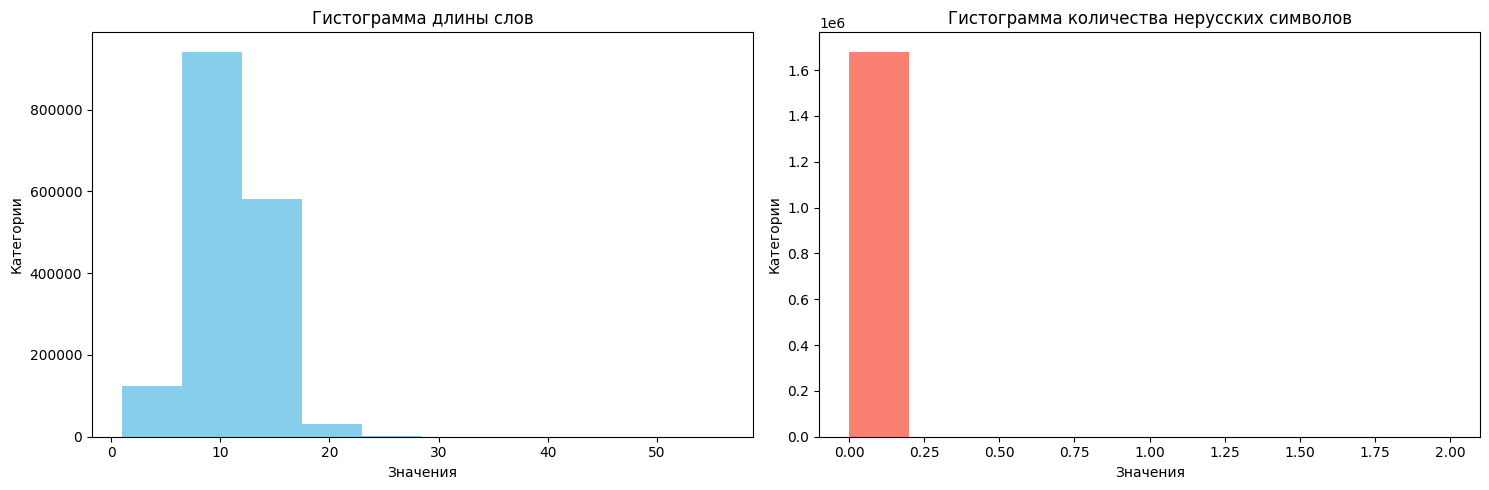

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(accents_dataset['word_length'], color='skyblue')
axs[0].set_title('–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ –¥–ª–∏–Ω—ã —Å–ª–æ–≤')
axs[1].hist(accents_dataset['num_non_russian'], color='salmon')
axs[1].set_title('–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –Ω–µ—Ä—É—Å—Å–∫–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤')
for ax in axs:
    ax.set_xlabel('–ó–Ω–∞—á–µ–Ω–∏—è')
    ax.set_ylabel('–ö–∞—Ç–µ–≥–æ—Ä–∏–∏')

plt.tight_layout()
plt.show()

In [22]:
print(f"95-–∫–≤–∞–Ω—Ç–∏–ª—å: {np.quantile(accents_dataset['word_length'].values, q = 0.95)}")

95-–∫–≤–∞–Ω—Ç–∏–ª—å: 16.0


In [23]:
len(accents_dataset[accents_dataset['word_length'] > 20])

4477

–î—É–º–∞—é 4500 –¥–ª–∏–Ω–Ω—ã—Ö —Å–ª–æ–≤ –º–æ–∂–Ω–æ –æ—Ç–±—Ä–æ—Å–∏—Ç—å

In [24]:
accents_dataset = accents_dataset[accents_dataset['word_length'] < 20]

–ò—Ç–∞–∫, –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç, —á—Ç–æ —Å—É—â–µ—Å—Ç–≤—É—é—Ç –æ—Å–æ–±—ã–µ —Å—ç–º–ø–ª—ã, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–≥—É—Ç –ø–æ–≤–ª–∏—è—Ç—å –Ω–∞ –æ–±–æ–±—â–∞—é—â—É—é —Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏. –û–¥–Ω–∞–∫–æ –∏—Ö –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–µ —Ç–∞–∫–æ–µ —É–∂ –∏ –±–æ–ª—å—à–æ–µ –∏, –≤ —Ü–µ–ª–æ–º, —Ç–∞–∫–∏–µ –ø—Ä–∏–º–µ—Ä—ã –∫–∞–∫ –æ–¥–Ω–∞ —Å–æ–≥–ª–∞—Å–Ω–∞—è –º–æ–≥—É—Ç –±—ã—Ç—å –¥–æ–≤–æ–ª—å–Ω–æ-—Ç–∞–∫–∏ –ø–æ–ª–µ–∑–Ω—ã–º–∏. –ü–æ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç–∏, –æ—Ç—Ñ–∏–ª—å—Ç—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ–∑–∂–µ.

–ö–∞–∫ –≤–∞—Ä–∏–∞–Ω—Ç –∏–Ω–æ—Å—Ç—Ä–∞–Ω–Ω—ã–µ —Å–∏–º–≤–æ–ª—ã –∏–∑ –ª–∞—Ç–∏–Ω—Å–∫–æ–π —Ä–∞—Å–∫–ª–∞–¥–∫–∏ –º–æ–∂–Ω–æ –∑–∞–º–µ–Ω–∏—Ç—å —Ç—Ä–∞–Ω—Å–ª–∏—Ç–µ—Ä–∞—Ü–∏–µ–π –Ω–∞ —Ä—É—Å—Å–∫–∏–µ —Å–∏–º–≤–æ–ª—ã –∏–ª–∏, –Ω–∞–ø—Ä–∏–º–µ—Ä, –Ω–µ–∏–∑–≤–µ—Å—Ç–Ω—ã–µ —Å–∏–º–≤–æ–ª—ã (–æ—Ç–ª–∏—á–∞—é—â–∏–µ—Å—è –æ—Ç "-") –≤–æ–æ–±—â–µ —É–±—Ä–∞—Ç—å –∏–ª–∏ –∑–∞–º–µ–Ω–∏—Ç—å –Ω–∞ –¥—Ä—É–≥–æ–π —Å–∏–º–≤–æ–ª. 

#### –ï—â–µ —Ö–æ—á–µ—Ç—Å—è –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å, –µ—Å—Ç—å –ª–∏ —Å—ç–º–ø–ª—ã, –≤ –∫–æ—Ç–æ—Ä—ã—Ö —Å–ª—É—á–∞–π–Ω–æ —Ä–∞—Å—Å—Ç–∞–≤–ª–µ–Ω—ã —É–¥–∞—Ä–µ–Ω–∏—è –Ω–∞ —Å–æ–≥–ª–∞—Å–Ω—É—é –±—É–∫–≤—É –∏ —Å—ç–º–ø–ª—ã, —Å–æ–¥–µ—Ä–∂–∞—â–∏–µ –±—É–∫–≤—É —ë–Å, —á—Ç–æ–±—ã –Ω–µ —É—á–∏—Ç—å –º–æ–¥–µ–ª—å –Ω–∞ –Ω–∏—Ö:

In [25]:
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—ç–º–ø–ª–æ–≤ —Å –±—É–∫–≤–æ–π –Å—ë: {accents_dataset[accents_dataset['is_–Å—ë'] != 0].shape[0]}")

print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—ç–º–ø–ª–æ–≤ —Å —É–¥–∞—Ä–µ–Ω–∏—è–º –Ω–∞ —Å–æ–≥–ª–∞—Å–Ω—É—é: {accents_dataset[accents_dataset['error_cases'] != 0].shape[0]}")

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—ç–º–ø–ª–æ–≤ —Å –±—É–∫–≤–æ–π –Å—ë: 0
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—ç–º–ø–ª–æ–≤ —Å —É–¥–∞—Ä–µ–Ω–∏—è–º –Ω–∞ —Å–æ–≥–ª–∞—Å–Ω—É—é: 0


–ò—Ç–∞–∫, –±—É–∫–≤ –Å—ë –∏ –æ—à–∏–±–æ–∫ —Å —É–¥–∞—Ä–µ–Ω–∏–µ–º –Ω–∞ —Å–æ–≥–ª–∞—Å–Ω—É—é –Ω–µ—Ç.

#### –í—Å—ë –∂–µ –ø–æ–ø—Ä–æ–±—É–µ–º –∑–∞–º–µ–Ω–∏—Ç –∞–Ω–≥–ª–∏–π—Å–∫–∏–µ —Å–∏–º–≤–æ–ª—ã —Ç—Ä–∞–Ω—Å–ª–∏—Ç–µ—Ä–∞—Ü–∏–µ–π:

In [ ]:
latin_to_russian_needed = {
    'c': '—Å', 'h': '–≥', 'j': '—ä', 'g': '–≥'
}

def transliterate(text):
    '''–î–µ–ª–∞–µ–º —Ç—Ä–∞–Ω—Å–ª–∏—Ç–µ—Ä–∞—Ü–∏—é –Ω–∞–π–¥–µ–Ω–Ω—ã—Ö –ª–∞—Ç–∏–Ω—Å–∫–∏—Ö –±—É–∫–≤ –∏ —Å–∏–º–≤–æ–ª–æ–≤'''
    return ''.join(latin_to_russian_needed.get(char, char) for char in text)

accents_dataset['words_upd'] = accents_dataset['-–¥–µ'].map(transliterate)

In [27]:
accents_dataset[accents_dataset['num_non_russian'] > 0].head()

-–¥–µ               -–¥^–µ  word_length  is_one_symbol  \
116704          –±—Éh–∞–ª—Ç–µ—Ä          –±—Éh^–∞–ª—Ç–µ—Ä            8              0   
116706  –±—Éh–∞–ª—Ç–µ—Ä-—Ä–µ–≤–∏–∑–æ—Ä  –±—Éh^–∞–ª—Ç–µ—Ä-—Ä–µ–≤–∏–∑–æ—Ä           16              0   
116707        –±—Éh–∞–ª—Ç–µ—Ä–∏—è        –±—Éh–∞–ª—Ç^–µ—Ä–∏—è           10              0   
116708       –±—Éh–∞–ª—Ç–µ—Ä—Å–∫–∏       –±—Éh^–∞–ª—Ç–µ—Ä—Å–∫–∏           11              0   
116709      –±—Éh–∞–ª—Ç–µ—Ä—Å–∫–∏–π      –±—Éh^–∞–ª—Ç–µ—Ä—Å–∫–∏–π           12              0   

        more_than_one_word  hat_num  has_latin  num_non_russian  error_cases  \
116704                   0        1          1                1            0   
116706                   0        1          1                1            0   
116707                   0        1          1                1            0   
116708                   0        1          1                1            0   
116709                   0        1          1                1            0   

        is_–Å—ë         words_upd  
116704      0          –±—É–≥–∞–ª—Ç–µ—Ä  
116706      0  –±—É–≥–∞–ª—Ç–µ—Ä-—Ä–µ–≤–∏–∑–æ—Ä  
116707      0        –±—É–≥–∞–ª—Ç–µ—Ä–∏—è  
116708      0       –±—É–≥–∞–ª—Ç–µ—Ä—Å–∫–∏  
116709      0      –±—É–≥–∞–ª—Ç–µ—Ä—Å–∫–∏–π

#### –£–±–µ—Ä–µ–º, –≥–¥–µ –Ω–µ—Ç —É–¥–∞—Ä–µ–Ω–∏–π:

In [28]:
accents_dataset = accents_dataset[accents_dataset['hat_num'] > 0]

#### –ò—Ç–æ–≥–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç –ø–æ—Å–ª–µ –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–π:

In [29]:
accents_dataset.shape

(1671254, 11)

In [30]:
accents_dataset.head(10)

-–¥–µ          -–¥^–µ  word_length  is_one_symbol  more_than_one_word  \
0           -–∫–∞          -–∫^–∞            3              0                   0   
1         -–ª–∏–±–æ        -–ª^–∏–±–æ            5              0                   0   
2       -–Ω–∏–±—É–¥—å      -–Ω–∏–±^—É–¥—å            7              0                   0   
4         -—Ç–∞–∫–∏        -—Ç–∞–∫^–∏            5              0                   0   
5           -—Ç–æ          -—Ç^–æ            3              0                   0   
6   ¬≠–≤—ã—á–µ—Ä–∫–Ω—É—Ç—å  ¬≠–≤^—ã—á–µ—Ä–∫–Ω—É—Ç—å           11              0                   0   
7             –∞            ^–∞            1              1                   0   
8       –∞-–∫–æ–Ω—Ç–æ      –∞-–∫^–æ–Ω—Ç–æ            7              0                   0   
9          –∞-–ª—è         –∞-–ª^—è            4              0                   0   
10    –∞-–º–æ–ª—å–Ω—ã–π    –∞-–º^–æ–ª—å–Ω—ã–π            9              0                   0   

    hat_num  has_latin  num_non_russian  error_cases  is_–Å—ë    words_upd  
0         1          0                0            0      0          -–∫–∞  
1         1          0                0            0      0        -–ª–∏–±–æ  
2         1          0                0            0      0      -–Ω–∏–±—É–¥—å  
4         1          0                0            0      0        -—Ç–∞–∫–∏  
5         1          0                0            0      0          -—Ç–æ  
6         1          0                0            0      0  ¬≠–≤—ã—á–µ—Ä–∫–Ω—É—Ç—å  
7         1          0                0            0      0            –∞  
8         1          0                0            0      0      –∞-–∫–æ–Ω—Ç–æ  
9         1          0                0            0      0         –∞-–ª—è  
10        1          0                0            0      0    –∞-–º–æ–ª—å–Ω—ã–π

#### –¢–µ–ø–µ—Ä—å –Ω—É–∂–Ω–æ –ø–æ–¥–≥–æ—Ç–æ–≤–∏—Ç—å –¥–∞–Ω–Ω—ã–µ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è

–ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ –µ—Å—Ç—å —Å–º—ã—Å–ª —Ä–∞–∑–¥–µ–ª–∏—Ç—å —Å–ª–æ–≤–æ –Ω–∞ —Ç–æ–∫–µ–Ω—ã, –ø—Ä–∏—á—ë–º –∫–∞–∂–¥–∞—è –±—É–∫–≤–∞ –±—É–¥–µ—Ç —è–≤–ª—è—Ç—å—Å—è —Ç–æ–∫–µ–Ω–æ–º. –î–∞–ª–µ–µ –º–æ–∂–Ω–æ –ø—Ä–∏—Å–≤–æ–∏—Ç—å –∫–∞–∂–¥–æ–º—É —Ç–æ–∫–µ–Ω—É –º–µ—Ç–∫—É 1 –∏–ª–∏ 0 –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç —Ç–æ–≥–æ, —è–≤–ª—è–µ—Ç—Å—è –ª–∏ –¥–∞–Ω–Ω—ã–π —Ç–æ–∫–µ–Ω —É–¥–∞—Ä–Ω—ã–º –∏–ª–∏ –Ω–µ—Ç –∏ –≤—ã–π—Ç–∏ –Ω–∞ —Å–≤–æ–µ–≥–æ —Ä–æ–¥–∞ –∑–∞–¥–∞—á—É –±–∏–Ω–∞—Ä–Ω–æ–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ç–æ–∫–µ–Ω–∞.

UPD: –ø–æ–∑–¥–Ω–µ–µ –æ—Ç –¥–∞–Ω–Ω–æ–π –∏–¥–µ–∏ –±—ã–ª–æ —Ä–µ—à–µ–Ω–æ –æ—Ç–∫–∞–∑–∞—Ç—å—Å—è –≤ –ø–æ–ª—å–∑—É –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ —É–¥–∞—Ä–Ω–æ–π –ø–æ–∑–∏—Ü–∏–∏ –≤ —Å–ª–æ–≤–µ. –ü–æ—Å–∫–æ–ª—å–∫–æ –º–µ—Ç–∫–∞ 1 –æ–¥–Ω–∞, –∞ –º–µ—Ç–æ–∫ 0 (–±–µ–∑—É–¥–∞—Ä–Ω–∞—è) –º–æ–∂–µ—Ç –±—ã—Ç—å –Ω–µ–º–∞–ª–æ, –º–æ–¥–µ–ª—å –º–æ–∂–µ—Ç –Ω–∞—á–∞—Ç—å –º–∏–Ω–∏–º–∏–∑–∏—Ä–æ–≤–∞—Ç—å –ª–æ—Å—Å —Å –ø—Ä–∏–æ—Ä–∏—Ç–µ—Ç–æ–º –ø–æ –±–µ–∑—É–¥–∞—Ä–Ω—ã–º –ø–æ–∑–∏—Ü–∏—è–º, —á—Ç–æ –Ω–µ –µ—Å—Ç—å —Ö–æ—Ä–æ—à–æ.

–û–¥–Ω–∞–∫–æ –ø–æ—Å—á–∏—Ç–∞–Ω–æ –∏ –ø–æ—Å—á–∏—Ç–∞–Ω–æ, –ø–µ—Ä–µ–π—Ç–∏ –∫ –∑–∞–¥–∞—á–µ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –Ω–µ —Å–æ—Å—Ç–∞–≤–∏—Ç –æ—Å–æ–±–æ–≥–æ —Ç—Ä—É–¥–∞!

In [ ]:
def get_marked_dict(dataset = accents_dataset,
			input_column = 'words_upd',
			predict_column = '-–¥^–µ'):
	
	'''
	–§—É–Ω–∫—Ü–∏—è, —Ä–µ–∞–ª–∏–∑—É—é—â–∞—è –ª–æ–≥–∏–∫—É –≤—ã–¥–µ–ª–µ–Ω–∏—è —É–¥–∞—Ä–Ω–æ–≥–æ —Ç–æ–∫–µ–Ω–∞ –≤ —Å–ª–æ–≤–µ
	
	–ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
	-dataset: –≤—ã–¥–µ–ª–µ–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç (default: accents_dataset)
	-input_column: –∫–æ–ª–æ–Ω–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞, –∫–æ—Ç–æ—Ä—É—é –±—É–¥–µ–º –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞—Ç—å (default: 'words_upd')
	-predict_column: –∫–æ–ª–æ–Ω–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞, –≥–¥–µ –±—É–¥–µ–º –∏—Å–∫–∞—Ç—å —É–¥–∞—Ä–µ–Ω–∏–µ (default: '-–¥^–µ')
	'''
	
	words = dataset[input_column].values
	words_accents = dataset[predict_column].values
	inputs = [word for word in words]
	labels = []
	
	for word, accents in tqdm(zip(words, words_accents)):
		label = [0] * (len(word) + 2)
		for i, char in enumerate(accents):
			if char == '^':
				label[i+1] = 1
				
		labels.append(label)
	return {"input_words" : inputs,
		"labels" : labels}
		
words_labels = get_marked_dict()

0it [00:00, ?it/s]

In [ ]:
def get_example(dict = words_labels,
                idx = 0):
    '''–ü–æ–ª—É—á–∞–µ–º —ç–∫–∑–µ–º–ø–ª—è—Ä –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏'''
    print(words_labels['input_words'][idx], words_labels['labels'][idx])
    
get_example(idx = 1001)

–∞–±–µ—Ä–¥–∏–Ω—Å–∫–æ–≥–æ [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
def convert_to_tokens(example):
    '''–ö–æ–Ω–≤–µ—Ä—Ç–µ—Ä —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ –≤ —Ç–æ–∫–µ–Ω'''
    result = tokenizer.convert_ids_to_tokens(example)
    return result

–í—Ä–æ–¥–µ –∫–∞–∫ —Ä–∞–∑–º–µ—á–µ–Ω–æ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ. –°–æ–∑–¥–∞–µ–º torc.utils.data.Dataset –∏–∑ —Å–ª–æ–≤–∞—Ä—è:

In [ ]:
class AccentDataset(Dataset):
	
	def __init__(self, words_labels = words_labels,
				tokenizer = tokenizer,
				max_len = 22):
		
		'''
		–ö–æ–Ω—Å—Ç—Ä—É–∫—Ç–æ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞ —É–¥–∞—Ä–µ–Ω–∏–π, –∫–æ—Ç–æ—Ä—ã–π –º—ã –∏ –±—É–¥–µ–º –ø–æ–¥–∞–≤–∞—Ç—å –≤ —Å–µ—Ç—å
		
		–ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
		-self
		-words_labels: –º–µ—Ç–∫–∏ –¥–ª—è —É–¥–∞—Ä–Ω–æ—Å—Ç–∏ –ø–æ–∑–∏—Ü–∏–π (default: words_labels, –ø–æ–ª—É—á–µ–Ω–Ω—ã–µ —Ä–∞–Ω–Ω–µ–µ)
		-tokenizer: —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä (default: tokenizer –∏–∑ —Ä–µ–ø–æ–∑–∏—Ç–æ—Ä–∏—è)
		-max_len: –æ–≥—Ä–∞–Ω–∏—á–∏–≤–∞–µ–º –º–∞–∫—Å–∏–º–∞–ª—å–Ω—É—é –¥–ª–∏–Ω—É —Å–ª–æ–≤–∞ (default: 22)
		'''
		self.data = words_labels
		self.tokenizer = tokenizer
		self.max_model_length = max_len
		
	def __len__(self):
		return len(self.data['input_words'])
	
	def __getitem__(self, idx, idx_to_token = False):
		input_word, accent_labels = self.data['input_words'][idx], self.data['labels'][idx]
		
		encoding = self.tokenizer.encode_plus(
			input_word,
			add_special_tokens=True,
			max_length=self.max_model_length,
			padding='max_length',
			truncation=True,
			return_attention_mask=True,
			return_tensors='pt',
		)
		
		input_ids = encoding['input_ids'].flatten()
		attention_mask = encoding['attention_mask'].flatten()
		token_type_ids = encoding['token_type_ids'].flatten()

		labels = torch.tensor(accent_labels, dtype=torch.long)
		padding_length = self.max_model_length - labels.size(0)
		idx = np.where(labels == 1)[0]
		if len(idx) == 0:
			print(input_ids)
			print(labels)
			print(convert_to_tokens(input_ids.tolist()))
		label = torch.tensor(idx)

		if idx_to_token == True:
			return {
				'input_ids': self.tokenizer.convert_ids_to_tokens(input_ids),
				'attention_mask': attention_mask,
				'token_type_ids': token_type_ids,
				'labels': torch.tensor(idx[0], dtype=torch.long)
				}
		return {
				'input_ids': input_ids,
				'attention_mask': attention_mask,
				'token_type_ids': token_type_ids,
				'labels': torch.tensor(idx[0], dtype=torch.long)
				}
	
	
words_labels_dataset = AccentDataset()

#### Check:

In [34]:
words_labels_dataset[168]['labels']

tensor(5)

In [35]:
len(words_labels_dataset)

1671254

In [36]:
words_labels_dataset[1001]

{'input_ids': tensor([ 0,  8, 10, 18, 42, 16, 26, 36, 44, 30, 38, 14, 38,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(6)}

In [37]:
words_labels_dataset.__getitem__(0, idx_to_token = True)

{'input_ids': ['[CLS]',
  '-',
  '–∫',
  '–∞',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(3)}

–í—Å—ë –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ. –¢–µ–ø–µ—Ä—å –Ω—É–∂–Ω–æ –Ω–∞–ø–∏—Å–∞—Ç—å —Ñ—É–Ω–∫—Ü–∏—é –ø–æ–ª—É—á–µ–Ω–∏—è –¥–∞—Ç–∞—Å–µ—Ç–æ–≤ –¥–ª—è train –∏ –¥–ª—è test.

In [ ]:
def get_datasets(dataset_cls = AccentDataset,
			max_len = 22, # 99% —Å–ª–æ–≤ –Ω–∏–∂–µ —ç—Ç–æ–π –¥–ª–∏–Ω—ã –ø–æ —Å–∏–º–≤–æ–ª–∞–º
			data = words_labels,
			tokenizer = tokenizer,
			train_size = 0.5):
	'''
	–§—É–Ω–∫—Ü–∏—è get_datasets() –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç train –∏ test –¥–∞—Ç–∞—Å–µ—Ç—ã –Ω–∞ –æ—Å–Ω–æ–≤–µ –∫–æ–Ω—Å—Ç—Ä—É–∫—Ç–æ—Ä–∞ AccentDataset, –¥–µ–ª–∞—è train_test_spilt
	
	–ü–∞—Ä–∞–º–µ—Ç—Ä—ã —Ñ—É–Ω–∫—Ü–∏–∏:
	-dataset_cls: –∫–ª–∞—Å—Å –¥–∞—Ç–∞—Å–µ—Ç–∞, –∫–æ—Ç–æ—Ä—ã–π –º—ã –±—É–¥–µ–º –ø–µ—Ä–µ–¥–≤–∞–≤–∞—Ç—å –≤ —Ñ—É–Ω–∫—Ü–∏—é –∏ —á–µ–π –∫–æ–Ω—Å—Ç—Ä—É–∫—Ç–æ—Ä –º—ã –±—É–¥–µ–º –≤—ã–∑—ã–≤–∞—Ç—å (default: AccentDataset)
	-max_ken: –º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–ª–∏–Ω–∞ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ —Ç–æ–∫–µ–Ω–æ–≤ (—Ä–µ—à–∏–ª –≤–∑—è—Ç—å 22, —Ç–∞–∫ –∫–∞–∫ —ç—Ç–æ 95% –∫–≤–∞–Ω—Ç–∏–ª—å —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Å–ª–æ–≤ –ø–æ –¥–ª–∏–Ω–∞–º)
	-data: –¥–∞–Ω–Ω—ã–µ (default: words_labels)
	-tokenizer: —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä (default: tokenizer)
	-train_size: —Ä–∞–∑–º–µ—Ä train –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è —Å–ø–ª–∏—Ç–∞ (default: 0.5 –∏–∑ –∑–∞–¥–∞–Ω–∏—è)
	'''
	# –í—ã–∑–æ–≤ –∫–æ–Ω—Å—Ç—Ä—É–∫—Ç–æ—Ä–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞
	dataset = dataset_cls(words_labels = data,
				tokenizer = tokenizer,
				max_len = max_len)
	
	# –£—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Ä–∞–∑–º–µ—Ä—ã
	train_size = int(train_size * len(dataset))
	test_size = len(dataset) - train_size
	train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

	# –í–æ–∑–≤—Ä–∞—â–∞–µ–º –¥–∞—Ç–∞—Å–µ—Ç—ã train + test		
	return train_dataset, test_dataset

train_dataset_, test_dataset = get_datasets()
	

#### Check:

In [40]:
len(train_dataset_), len(test_dataset)

(835627, 835627)

#### –ü—Ä–æ–≤–µ—Ä–∏–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π —Å—ç–º–ø–ª:

In [41]:
train_dataset_[2]

{'input_ids': tensor([ 0, 24,  8, 40,  8, 52,  8, 36, 36, 48, 70,  1,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(4)}

In [42]:
print(convert_to_tokens(train_dataset_[2]['input_ids'].tolist()))

['[CLS]', '–∑', '–∞', '–ø', '–∞', '—Ö', '–∞', '–Ω', '–Ω', '—É', '—é', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [43]:
train_dataset_[2]['labels']

tensor(4)

#### –ü—Ä–æ–≤–µ—Ä–∏–º —Ç–µ—Å—Ç–æ–≤—ã–π —Å—ç–º–ø–ª:

In [44]:
test_dataset[2]

{'input_ids': tensor([ 0, 48, 54, 18, 40, 32, 72, 70, 46,  1,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(6)}

In [45]:
print(convert_to_tokens(test_dataset[2]['input_ids'].tolist()))

['[CLS]', '—É', '—Ü', '–µ', '–ø', '–ª', '—è', '—é', '—Ç', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [46]:
test_dataset[2]['labels']

tensor(6)

–í—Å—ë —Ä–∞–±–æ—Ç–∞–µ—Ç!

#### –¢–µ–ø–µ—Ä—å –Ω—É–∂–Ω–æ —Å–¥–µ–ª–∞—Ç—å train_val_split:

In [ ]:
def train_val_split(dataset = train_dataset_,
				train_size = 0.9):
	
	'''
	–§—É–Ω–∫—Ü–∏—è –¥–ª—è —Å–æ–∑–¥–∞–Ω–∏—è –∏—Å–∫–æ–º–æ–≥–æ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –∏ –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–≥–æ –º–Ω–æ–∂–µ—Å—Ç–≤–∞

	–ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
	-dataset: —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç, –∫–æ—Ç–æ—Ä—ã–π –±—É–¥–µ—Ç —Ä–∞–∑–±–∏–≤–∞—Ç—å—Å—è –Ω–∞ train x val (default: train_dataset_)
	-train_size: —Ä–∞–∑–º–µ—Ä –∏—Å–∫–æ–º–æ–≤–æ–≥–æ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞ –æ—Ç –ø–µ—Ä–µ–¥–∞–≤–∞–µ–º–æ–≥–æ (default: 0.9)
	'''
	
	# –û–±—ä—è–≤–ª—è–µ–º —Ä–∞–∑–º–µ—Ä—ã train x val
	train_size = int(train_size * len(dataset))
	val_size = len(dataset) - train_size
	
	# –î–µ–ª–∞–µ–º —Å–ø–ª–∏—Ç –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π –∏ —Ç–µ—Å—Ç–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç—ã
	train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
	return train_dataset, val_dataset

train_dataset, val_dataset = train_val_split()

#### Check:

In [48]:
len(train_dataset), len(val_dataset)

(752064, 83563)

In [49]:
train_dataset[2]['labels']

tensor(10)

In [ ]:
def get_loaders(train_dataset = train_dataset,
				val_dataset = val_dataset,
			test_dataset = test_dataset,
			shuffle_train = True,
			shuffle_val = False,
				shuffle_test = False,
			batch_size = 128):
	'''
	–§—É–Ω–∫—Ü–∏—è get_loaders() –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è train, val –∏ test –¥–∞—Ç–∞–ª–æ–∞–¥–µ—Ä–æ–≤

	–ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
	-train_dataset: —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç (default: train_dataset)
	-val_dataset: –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç (default: val_dataset)
	-test_dataset: —Ç–µ—Å—Ç–æ–≤—ã–π –¥–∞—Ç–∞—Å–µ—Ç (default: test_dataset)
	-shuffle_train: —Ñ–ª–∞–≥ –ø–µ—Ä–µ–º–µ—à–∏–≤–∞–Ω–∏—è –¥–ª—è train (default: True)
	-shuffle_val: —Ñ–ª–∞–≥ –ø–µ—Ä–µ–º–µ—à–∏–≤–∞–Ω–∏—è –¥–ª—è val (default: False)
	-shuffle_test: —Ñ–ª–∞–≥ –ø–µ—Ä–µ–º–µ—à–∏–≤–∞–Ω–∏—è –¥–ª—è test (default: False)
	-batch_size: —Ä–∞–∑–º–µ—Ä –±–∞—Ç—á–∞ –¥–∞–Ω–Ω—ã—Ö (default: 128)
	'''
	
	# train_dataloader
	train_dataloader = DataLoader(
			train_dataset,   
			batch_size = batch_size,
			shuffle = shuffle_train,
		)

	# validation_dataloader
	validation_dataloader = DataLoader(
			val_dataset, 
			batch_size = batch_size,
			shuffle = shuffle_val,
		)
	
	# test_dataloader
	test_dataloader = DataLoader(
			test_dataset, 
			batch_size = batch_size,
			shuffle = shuffle_test,
		)
	
	# –í–æ–∑–≤—Ä–∞—â–∞–µ–º –¥–∞—Ç–∞–ª–æ–∞–¥–µ—Ä—ã
	return train_dataloader, validation_dataloader, test_dataloader

train_dataloader, validation_dataloader, test_dataloader = get_loaders()


#### Check:

In [52]:
train_dataloader.dataset[0]

{'input_ids': tensor([ 0, 12, 18, 46, 18, 42, 26, 36,  8, 42, 36, 38, 34,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(8)}

In [53]:
validation_dataloader.dataset[0]

{'input_ids': tensor([ 0, 42,  8, 44, 56, 18, 44, 64, 12,  8, 18, 34, 64,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(2)}

#### Check –∏—Ç–µ—Ä–∏—Ä–æ–≤–∞–Ω–∏—è:

In [54]:
for i, batch in enumerate(tqdm(train_dataloader)):
#     pass
    print(batch['input_ids'][0])
    print(len(batch['attention_mask'][0]))
    print(batch['labels'][0])
    print(convert_to_tokens(batch['input_ids'][0].tolist()))
    if i == 0:
        break

  0%|          | 0/5876 [00:00<?, ?it/s]

tensor([ 0, 40, 42, 26, 52, 32, 18, 44, 46, 36, 18, 46, 18,  1,  4,  4,  4,  4,
         4,  4,  4,  4])
22
tensor(10)
['[CLS]', '–ø', '—Ä', '–∏', '—Ö', '–ª', '–µ', '—Å', '—Ç', '–Ω', '–µ', '—Ç', '–µ', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


#### –ì–æ—Ç–æ–≤–∏–º—Å—è –æ–±—É—á–∞—Ç—å... –í —ç—Ç–æ—Ç —Ä–∞–∑ DeBERTa –º–æ–¥–µ–ª—å!

In [ ]:
from transformers import DebertaForSequenceClassification, Trainer, TrainingArguments

# –ò–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º –º–æ–¥–µ–ª—å –¥–ª—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –ø–æ—Å–ª–µ–∂–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–µ–π
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=20)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# –ü–µ—Ä–µ–±—Ä–∞—Å—ã–≤–∞–µ–º –º–æ–¥–µ–ª—å –Ω–∞ device
model.to(device)


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

#### –ù–∞—à–µ–ª –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç—å –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è —Å –ø–æ–º–æ—â—å—é wandb.ai (Weights and Biases):

#### –ê—Ä–≥—É–º–µ–Ω—Ç—ã:

In [ ]:
import wandb
wandb.login(key='### HERE_WAS_MY_API_KEY ###')

wandb.init(project='DaBERTa_Accents_GO', config={
    'learning_rate': 3e-5,
    'epochs': 15,
    'batch_size': 128,
})


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 4ervonec19 (4ervonec19-bauman-moscow-state-technical-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241109_232407-y4ak9gnv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bright-cherry-1
wandb: ‚≠êÔ∏è View project at https://wandb.ai/4ervonec19-bauman-moscow-state-technical-university/DaBERTa_Accents_GO
wandb: üöÄ View run at https://wandb.ai/4erv

In [ ]:
from sklearn.metrics import accuracy_score


def compute_metrics(eval_pred):
    '''–§—É–Ω–∫—Ü–∏—è –ø–æ–¥—Å—á–µ—Ç–∞ –º–µ—Ç—Ä–∏–∫–∏ accuracy'''
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions)
    }


'''–ê—Ä–≥—É–º–µ–Ω—Ç—ã, –ø–µ—Ä–µ–¥–∞–≤–∞–µ–º—ã–µ –≤ wandb.ai –æ–±–µ—Ä—Ç–∫—É'''
training_args = TrainingArguments(
    output_dir='./results', # –ü—É—Ç—å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    evaluation_strategy='epoch', # –í–∞–ª–∏–¥–∞—Ü–∏—è —á–µ—Ä–µ–∑ —ç–ø–æ—Ö—É
    save_strategy='epoch', # –°–æ–∑—Ä–∞–Ω–µ–Ω–∏–µ —á–µ—Ä–µ–∑ —ç–ø–æ—Ö—É
    learning_rate=wandb.config['learning_rate'], # –®–∞–≥ —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏ –∏–∑ config
    per_device_train_batch_size=wandb.config['batch_size'], # –†–∞–∑–º–µ—Ä train-–±–∞—Ç—á–∞ –∏–∑ config
    per_device_eval_batch_size=wandb.config['batch_size'], # –†–∞–∑–º–µ—Ä val-–±–∞—Ç—á–∞ –∏–∑ config
    num_train_epochs=wandb.config['epochs'], # –ß–∏—Å–ª–æ —ç–ø–æ—Ö –∏–∑ config
    weight_decay=0.01, # Weight decay
    logging_dir='./logs', # –ü–∞–ø–∫–∞ –¥–ª—è –ª–æ–≥–æ–≤
    logging_steps=10,
    gradient_accumulation_steps=2, # –®–∞–≥–æ–≤ –Ω–∞–∫–æ–ø–ª–µ–Ω–∏—è –≥—Ä–∞–¥–∏–µ–Ω—Ç–æ–≤
    load_best_model_at_end=True, 
    metric_for_best_model='accuracy', # –ú–µ—Ç—Ä–∏–∫–∞ –æ—Ç–±–æ—Ä–∞ –ª—É—á—à–µ –º–æ–¥–µ–ª–∏ 
    save_total_limit=2, # –°–∫–æ–ª—å–∫–æ –º–æ–¥–µ–ª–µ–π –±—É–¥–µ–º —Å–æ—Ö—Ä–∞–Ω—è—Ç—å
    report_to='wandb'
)

#### Train:

In [ ]:
'''–û–±—ä—è–≤–ª–µ–Ω–∏–µ trainer –≤ –≤–∏–¥–µ –∫–æ–Ω—Å—Ç—Ä—É–∫—Ç–æ—Ä–∞'''
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset, 
    compute_metrics=compute_metrics
)

In [ ]:
'''–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏'''
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


TrainOutput(global_step=44070, training_loss=0.16563484262576145, metrics={'train_runtime': 32025.1183, 'train_samples_per_second': 352.254, 'train_steps_per_second': 1.376, 'total_flos': 1.4863728296710656e+17, 'train_loss': 0.16563484262576145, 'epoch': 15.0})

In [60]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ‚ñÅ‚ñÑ‚ñÖ‚ñÜ‚ñÜ‚ñá‚ñá‚ñá‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà
wandb:               eval/loss ‚ñà‚ñÖ‚ñÉ‚ñÉ‚ñÇ‚ñÇ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ
wandb:            eval/runtime ‚ñÅ‚ñÇ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÉ‚ñÜ‚ñá‚ñÖ‚ñÖ‚ñÖ‚ñà‚ñà‚ñà
wandb: eval/samples_per_second ‚ñà‚ñá‚ñà‚ñà‚ñà‚ñá‚ñÜ‚ñÉ‚ñÇ‚ñÑ‚ñÑ‚ñÑ‚ñÅ‚ñÅ‚ñÅ
wandb:   eval/steps_per_second ‚ñà‚ñá‚ñà‚ñà‚ñà‚ñá‚ñÜ‚ñÉ‚ñÇ‚ñÑ‚ñÑ‚ñÑ‚ñÅ‚ñÅ‚ñÅ
wandb:             train/epoch ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñá‚ñá‚ñà‚ñà‚ñà
wandb:       train/global_step ‚ñÅ‚ñÅ‚ñÅ‚ñÅ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÇ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÉ‚ñÑ‚ñÑ‚ñÑ‚ñÑ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÖ‚ñÜ‚ñÜ‚ñÜ‚ñÜ‚ñá‚ñá‚ñá‚ñà‚ñà‚ñà
wandb:         train/grad_norm ‚ñà‚ñà‚ñÜ‚ñÉ‚ñÑ‚ñÉ‚ñÇ‚ñÇ‚ñÅ‚ñÇ‚ñÉ‚ñÇ‚ñÉ‚ñÉ‚ñÇ‚ñÉ‚ñÇ‚ñÉ‚ñÇ‚ñÇ‚ñÉ‚ñÅ‚ñÉ‚ñÑ‚ñÇ‚ñÖ‚ñÜ‚ñÇ‚ñÇ‚ñÉ‚ñÇ‚ñÅ‚ñÅ‚ñÉ‚ñÉ‚ñÇ‚ñÉ‚ñÅ‚ñÉ‚ñÇ
wandb:     train/learning_rate ‚ñà‚ñà‚ñà‚ñà‚

#### –°—Å—ã–ª–∫–∞ –Ω–∞ –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–µ:

https://wandb.ai/4ervonec19-bauman-moscow-state-technical-university/DaBERTa_Accents_GO?nw=nwuser4ervonec19